In [ ]:
# link colab to drive
from google.colab import drive 
drive.mount('/content/gdrive')
% cd /content/gdrive/MyDrive/Project/Fake_fire
% ls

Mounted at /content/gdrive
/content/gdrive/MyDrive/Project/Fake_fire
data/  models/  output_model/  pretrained/  SSDMobileNet.ipynb


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()
!nvidia-smi

Fri May 27 00:44:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    27W /  70W |    264MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# mkdir folder data/split_data and split train test 
import os
import glob
import random
import shutil

raw_data_path = "/content/gdrive/MyDrive/Project/Fake_fire/data/images"
train_data_path = "/content/gdrive/MyDrive/Project/Fake_fire/data/split_data/train"
test_data_path = "/content/gdrive/MyDrive/Project/Fake_fire/data/split_data/test"

if not os.path.exists("/content/gdrive/MyDrive/Project/Fake_fire/data/split_data/"):
  os.mkdir("/content/gdrive/MyDrive/Project/Fake_fire/data/split_data/")
  
try:
  shutil.rmtree(train_data_path)
  shutil.rmtree(test_data_path)
except:
  pass

os.mkdir(train_data_path)
os.mkdir(test_data_path)

total_files = glob.glob(raw_data_path + "/*.jpg")
print("Sample file = ", total_files[0])
print("Total file = ", len(total_files))

indices = list(range(len(total_files)))
train_indices = random.sample(indices, k = int(len(total_files)*0.9))
print("Total train file = ", len(train_indices), " ,Total test file", len(total_files) - len(train_indices))

for i in indices:
   
    if (i in train_indices):
        # Copy to train
        shutil.copy(total_files[i], train_data_path + total_files[i].replace(raw_data_path,""))
        shutil.copy(total_files[i].replace("images","labels").replace(".jpg",".xml"),
                    train_data_path + total_files[i].replace(raw_data_path, "").replace(".jpg",".xml"))
    else:
        # Copy to test
        shutil.copy(total_files[i], test_data_path + total_files[i].replace(raw_data_path, ""))
        shutil.copy(total_files[i].replace("images", "labels").replace(".jpg", ".xml"),
                    test_data_path + total_files[i].replace(raw_data_path, "").replace(".jpg",".xml"))


Sample file =  /content/gdrive/MyDrive/Project/Fake_fire/data/images/living_1.jpg
Total file =  651
Total train file =  585  ,Total test file 66


In [ ]:
# 3.Convert XML label to CSV.
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

for directory in ['train','test']:
        image_path = os.path.join('/content/gdrive/MyDrive/Project/Fake_fire/data/split_data/{}'.format(directory))
        xml_df = xml_to_csv(image_path)
        xml_df.to_csv('/content/gdrive/MyDrive/Project/Fake_fire/data/split_data/{}_labels.csv'.format(directory), index=None)
        print('Successfully converted xml to csv.')


Successfully converted xml to csv.
Successfully converted xml to csv.


In [ ]:
# 4. Download TF Object Detection APi to dir models
%cd /content/gdrive/MyDrive/Project/Fake_fire
!git clone https://github.com/tensorflow/models.git


/content/gdrive/MyDrive/Project/Fake_fire
Cloning into 'models'...
remote: Enumerating objects: 72954, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 72954 (delta 62), reused 93 (delta 48), pack-reused 72825
Receiving objects: 100% (72954/72954), 579.28 MiB | 12.49 MiB/s, done.
Resolving deltas: 100% (51611/51611), done.
Checking out files: 100% (3042/3042), done.
[Errno 2] No such file or directory: 'ls'
/content/gdrive/MyDrive/Project/Fake_fire


In [ ]:
%ls

data/  models/  output_model/  pretrained/  SSDMobileNet.ipynb


In [ ]:
# 5. Compile the protos -  
# Protocol Buffers (Protobuf) is a free and open-source cross-platform data format used to serialize structured data.
%cd /content/gdrive/MyDrive/Project/Fake_fire/models/research
!protoc object_detection/protos/*.proto --python_out=.

/content/gdrive/MyDrive/Project/Fake_fire/models/research


In [ ]:
%cd /content/gdrive/MyDrive/Project/Fake_fire/models/research
#!cp object_detection/packages/tf2/setup.py . 
!python -m pip --use-feature=in-tree-build install .


/content/gdrive/MyDrive/Project/Fake_fire/models/research
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/gdrive/MyDrive/Project/Fake_fire/models/research
     |████████████████████████████████| 10.3 MB 7.0 MB/s 
     |████████████████████████████████| 352 kB 69.0 MB/s 
     |████████████████████████████████| 1.8 MB 65.1 MB/s 
     |████████████████████████████████| 23.1 MB 26.2 MB/s 
     |████████████████████████████████| 1.3 MB 64.6 MB/s 
     |████████████████████████████████| 2.1 MB 58.1 MB/s 
     |████████████████████████████████| 47.8 MB 109 kB/s 
     |████████████████████████████████| 596 kB 68.3 MB/s 
     |████████████████████████████████| 92 kB 13.5 MB/s 
     |████████████████████████████████| 1.1 MB 69.2 MB/s 
     |████████████████████████████████| 99 kB 11.9 MB/s 
     |████████████████████████████████| 4.6 MB 56.3 MB/s 
     |████████████████████████████████| 237 kB 81.2 MB/s 
     |███████████████

In [ ]:
# 7. Test API
!python object_detection/builders/model_builder_tf2_test.py


Running tests under Python 3.7.13: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2022-05-27 00:52:43.733826: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
W0527 00:52:43.987064 139882441721728 model_builder.py:1102] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 1.64s
I0527 00:52:44.449035 139882441721728 test_util.py:2309] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 1.64s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 0.68s
I0527 00:52:45.130541 139882441721728 test

In [ ]:
import os
# 8. CSV to TFRecord. With help from MiAI git hub
%cd /content/gdrive/MyDrive/Project/Fake_fire/models/research
#!git clone https://github.com/thangnch/MiAI_SSD_TF2
%ls
#!cp MiAI_SSD_TF2/generate_tfrecord.py .
#!cp MiAI_SSD_TF2/label_map.txt /content/gdrive/MyDrive/Project/Fake_fire/data

if not os.path.exists("/content/gdrive/MyDrive/Project/Fake_fire/data/tfrecord_data/"):
  os.mkdir("/content/gdrive/MyDrive/Project/Fake_fire/data/tfrecord_data/")

!python generate_tfrecord.py --image_dir=/content/gdrive/MyDrive/Project/Fake_fire/data/split_data/train --csv_input=/content/gdrive/MyDrive/Project/Fake_fire/data/split_data/train_labels.csv --output_path=/content/gdrive/MyDrive/Project/Fake_fire/data/tfrecord_data/train.record 
!python generate_tfrecord.py --image_dir=/content/gdrive/MyDrive/Project/Fake_fire/data/split_data/test --csv_input=/content/gdrive/MyDrive/Project/Fake_fire/data/split_data/test_labels.csv --output_path=/content/gdrive/MyDrive/Project/Fake_fire/data/tfrecord_data/test.record


/content/gdrive/MyDrive/Project/Fake_fire/models/research
adversarial_text/    delf/                   object_detection/
attention_ocr/       efficient-hrl/          object_detection.egg-info/
audioset/            generate_tfrecord.py    pcl_rl/
autoaugment/         lfads/                  README.md
build/               lstm_object_detection/  rebar/
cognitive_planning/  marco/                  seq_flow_lite/
cvt_text/            MiAI_SSD_TF2/           setup.py
deeplab/             model_main_tf2.py       slim/
deep_speech/         nst_blogpost/           vid2depth/
Successfully created the TFRecords: /content/gdrive/MyDrive/Project/Fake_fire/data/tfrecord_data/train.record
Successfully created the TFRecords: /content/gdrive/MyDrive/Project/Fake_fire/data/tfrecord_data/test.record


In [ ]:
# 9. Download pretrain and config
if not os.path.exists("/content/gdrive/MyDrive/Project/Fake_fire/pretrained"):
  os.mkdir("/content/gdrive/MyDrive/Project/Fake_fire/pretrained")

%cd /content/gdrive/MyDrive/Project/Fake_fire/pretrained
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
# Unzip
!tar -xzvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

# Config pipeline.config, label_map.txt if needed



In [ ]:
# Upload label file object-detection.txt to data folder
%cd /content/gdrive/MyDrive/Project/Fake_fire/models
#!pip install -r /content/gdrive/MyDrive/Project/Fake_fire/models/research/MiAI_SSD_TF2/setup.txt
!pip install --upgrade opencv-python

/content/gdrive/MyDrive/Project/Fake_fire/models
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.5 MB 1.4 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# Train
%cd /content/gdrive/MyDrive/Project/Fake_fire/models/research
%cp /content/gdrive/MyDrive/Project/Fake_fire/models/research/object_detection/model_main_tf2.py .

#train 
!python model_main_tf2.py \
--pipeline_config_path=/content/gdrive/MyDrive/Project/Fake_fire/pretrained/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config \
--model_dir=/content/gdrive/MyDrive/Project/Fake_fire/output_model --alsologtostderr --num_train_steps=40000

/content/gdrive/MyDrive/Project/Fake_fire/models/research
2022-05-27 02:13:07.759018: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0527 02:13:07.762673 140495236355968 mirrored_strategy.py:376] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 40000
I0527 02:13:07.768109 140495236355968 config_util.py:552] Maybe overwriting train_steps: 40000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0527 02:13:07.768289 140495236355968 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W0527 02:13:07.907870 140495236355968 deprecation.py:347] From /content/gdrive/MyDrive/Project/Fake_fir

In [ ]:
# Export model
%cd /content/gdrive/MyDrive/Project/Fake_fire/models/research
%cp /content/gdrive/MyDrive/Project/Fake_fire/models/research/object_detection/exporter_main_v2.py .

!python exporter_main_v2.py \
--trained_checkpoint_dir=/content/gdrive/MyDrive/Project/Fake_fire/output_model \
--pipeline_config_path=/content/gdrive/MyDrive/Project/Fake_fire/pretrained/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config \
--output_directory=/content/gdrive/MyDrive/Project/Fake_fire/export_model


/content/gdrive/MyDrive/Project/Fake_fire/models/research
2022-05-27 02:14:51.944063: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0527 02:14:52.080768 139873715361664 deprecation.py:619] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:464: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradien

In [ ]:
import io
import os
import scipy.misc
import numpy as np
import six
import time
import glob
from IPython.display import display

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

#Load model
tf.keras.backend.clear_session()
model = tf.saved_model.load("/content/gdrive/MyDrive/Project/Fake_fire/export_model/saved_model")


In [ ]:
# Các hàm inference

import cv2
def run_inference_for_single_image(model, image):
  
  image = np.asarray(image)
  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis,...]

  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  if 'detection_masks' in output_dict:
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

def load_image_into_numpy_array(path):
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


/content/gdrive/MyDrive/Project/Fake_fire/models/research
Done load image 
Done inference
Done draw on image 


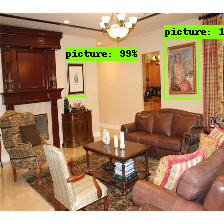

In [ ]:
%cd /content/gdrive/MyDrive/Project/Fake_fire/models/research
category_index = label_map_util.create_category_index_from_labelmap("/content/gdrive/MyDrive/Project/Fake_fire/data/label_map.txt", use_display_name=True)

image_path = '/content/gdrive/MyDrive/Project/Fake_fire/data/split_data/test/living_901.jpg'
image_np = load_image_into_numpy_array(image_path)
print("Done load image ")
#image_np = cv2.resize(image_np, dsize=None, fx=0.2, fy=0.2)
output_dict = run_inference_for_single_image(model, image_np)
print("Done inference")
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks_reframed', None),
    use_normalized_coordinates=True,
    line_thickness=1)
print("Done draw on image ")
display(Image.fromarray(image_np))

In [ ]:
%cd /content/gdrive/MyDrive/Project/Fake_fire/models/research
category_index = label_map_util.create_category_index_from_labelmap("/content/gdrive/MyDrive/Project/Fake_fire/data/label_map.txt", use_display_name=True)

image_path = '/content/gdrive/MyDrive/Project/Fake_fire/data/split_data/test/d99f7207f4652ad4.jpg'
image_np = load_image_into_numpy_array(image_path)
print("Done load image ")
#image_np = cv2.resize(image_np, dsize=None, fx=0.2, fy=0.2)
output_dict = run_inference_for_single_image(model, image_np)
print("Done inference")
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks_reframed', None),
    use_normalized_coordinates=True,
    line_thickness=1)
print("Done draw on image ")
display(Image.fromarray(image_np))

/content/gdrive/MyDrive/Project/Fake_fire/models/research


NotFoundError: ignored

/content/gdrive/MyDrive/Project/Fake_fire/models/research
Done load image 
Done inference
Done draw on image 


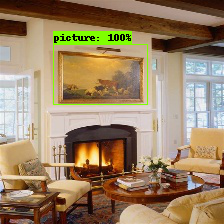

In [ ]:
%cd /content/gdrive/MyDrive/Project/Fake_fire/models/research
category_index = label_map_util.create_category_index_from_labelmap("/content/gdrive/MyDrive/Project/Fake_fire/data/label_map.txt", use_display_name=True)

image_path = '/content/gdrive/MyDrive/Project/Fake_fire/data/split_data/test/living_1191.jpg'
image_np = load_image_into_numpy_array(image_path)
print("Done load image ")
#image_np = cv2.resize(image_np, dsize=None, fx=0.2, fy=0.2)
output_dict = run_inference_for_single_image(model, image_np)
print("Done inference")
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks_reframed', None),
    use_normalized_coordinates=True,
    line_thickness=1)
print("Done draw on image ")
display(Image.fromarray(image_np))

In [ ]:
%cd /content/gdrive/MyDrive/Project/Fake_fire/models/research
category_index = label_map_util.create_category_index_from_labelmap("/content/gdrive/MyDrive/Project/Fake_fire/data/label_map.txt", use_display_name=True)

image_path = '/content/gdrive/MyDrive/Project/Fake_fire/data/split_data/test/istockphoto-1197070855-1024x1024.jpg'
image_np = load_image_into_numpy_array(image_path)
print("Done load image ")
#image_np = cv2.resize(image_np, dsize=None, fx=0.2, fy=0.2)
output_dict = run_inference_for_single_image(model, image_np)
print("Done inference")
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks_reframed', None),
    use_normalized_coordinates=True,
    line_thickness=1)
print("Done draw on image ")
display(Image.fromarray(image_np))

/content/gdrive/MyDrive/Project/Fake_fire/models/research


NotFoundError: ignored

In [ ]:
%cd /content/gdrive/MyDrive/Project/Fake_fire/models/research
category_index = label_map_util.create_category_index_from_labelmap("/content/gdrive/MyDrive/Project/Fake_fire/data/label_map.txt", use_display_name=True)

image_path = '/content/gdrive/MyDrive/Project/Fake_fire/data/split_data/test/your-room1.jpg'
image_np = load_image_into_numpy_array(image_path)
print("Done load image ")
#image_np = cv2.resize(image_np, dsize=None, fx=0.2, fy=0.2)
output_dict = run_inference_for_single_image(model, image_np)
print("Done inference")
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks_reframed', None),
    use_normalized_coordinates=True,
    line_thickness=1)
print("Done draw on image ")
display(Image.fromarray(image_np))

/content/gdrive/MyDrive/Project/Fake_fire/models/research


NotFoundError: ignored